# Import Libraries

In [15]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmocr
import matplotlib.pyplot as plt
import cv2

from imutils.object_detection import non_max_suppression
from skewness import *

2.0.1 True


# Visualize Result

In [16]:
img = cv2.imread('images/test1.jpg')

In [17]:
from mmocr.apis import MMOCRInferencer
ocr = MMOCRInferencer(det='TextSnake')
det = ocr(img, show=True, print_result=True)

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

In [18]:
boxes = det['predictions'][0]['det_polygons']

In [19]:
len(boxes)

5

In [20]:
image_rect = img.copy()
for box in boxes:
    count = len(box)

    x_box = [x for x in range(count) if x%2==0]
    y_box = [y for y in range(count) if y%2==1]
    
    x_min = round(min([box[x] for x in x_box]))
    y_min = round(min([box[y] for y in y_box]))
    x_max = round(max([box[x] for x in x_box]))
    y_max = round(max([box[y] for y in y_box]))
    image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_max,y_max), (255,0,0), 2)

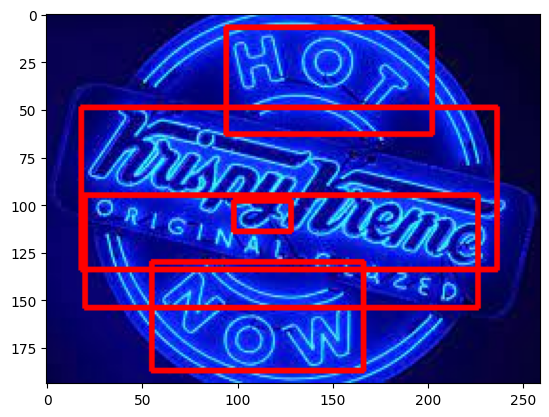

In [21]:
plt.imshow(image_rect)

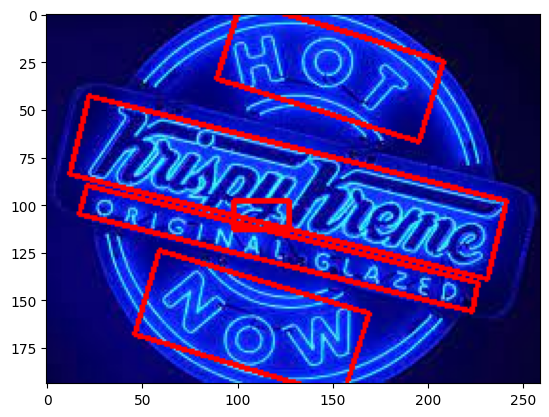

In [22]:
angled_boxes = []
for box in boxes:
    if len(box) >= 3:  # Ensure at least 3 points for a polygon
        # Convert box points to numpy array for easier manipulation
        box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

        # Calculate the minimum bounding rectangle
        rotated_rect = cv2.minAreaRect(box_points)
        box_vertices = cv2.boxPoints(rotated_rect)
        box_vertices = np.int0(box_vertices)
        angled_boxes.append(box_vertices)
        # Draw the rotated rectangle
        cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)

plt.imshow(img)

In [23]:
angled_boxes

[array([[ 46, 168],
        [ 59, 124],
        [169, 157],
        [155, 201]], dtype=int64),
 array([[ 98,  98],
        [127,  98],
        [127, 113],
        [ 98, 113]], dtype=int64),
 array([[ 17, 105],
        [ 21,  90],
        [226, 141],
        [223, 156]], dtype=int64),
 array([[ 12,  84],
        [ 22,  43],
        [241,  98],
        [231, 139]], dtype=int64),
 array([[ 89,  34],
        [102,  -7],
        [208,  25],
        [195,  67]], dtype=int64)]

In [24]:
largest_contour = max(angled_boxes, key=cv2.contourArea)

In [44]:
largest_contour

array([[ 12,  84],
       [ 22,  43],
       [241,  98],
       [231, 139]], dtype=int64)

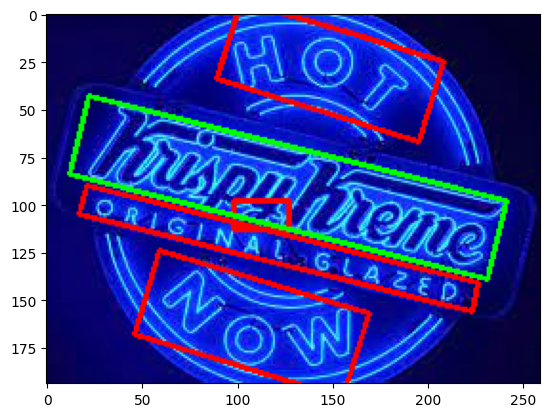

In [51]:
test = img.copy()
# test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
contours = [largest_contour]
cv2.drawContours(test, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
plt.imshow(test)

In [25]:
st_boxes = []
print(angled_boxes[0])

swapped_coordinates = angled_boxes[3].copy()
# swapped_coordinates[0], swapped_coordinates[1] = angled_boxes[3][1], angled_boxes[3][2]
# swapped_coordinates[2], swapped_coordinates[3] = angled_boxes[3][0], angled_boxes[3][3]
points,h,w = get_destination_points(angled_boxes[3])


[[ 46 168]
 [ 59 124]
 [169 157]
 [155 201]]

The destination points are: 

A' : [0. 0.]
B' : [41.  0.]
C' : [  0. 228.]
D' : [ 41. 228.]

The approximated height and width of the original image is: 
 (229, 42)



The homography matrix is: 
 [[ 4.70761913e-02 -7.70031986e-01  6.41177725e+01]
 [-7.66669400e-01 -1.86992537e-01  2.49074059e+01]
 [-6.72517018e-03 -1.64028541e-03  1.00000000e+00]]


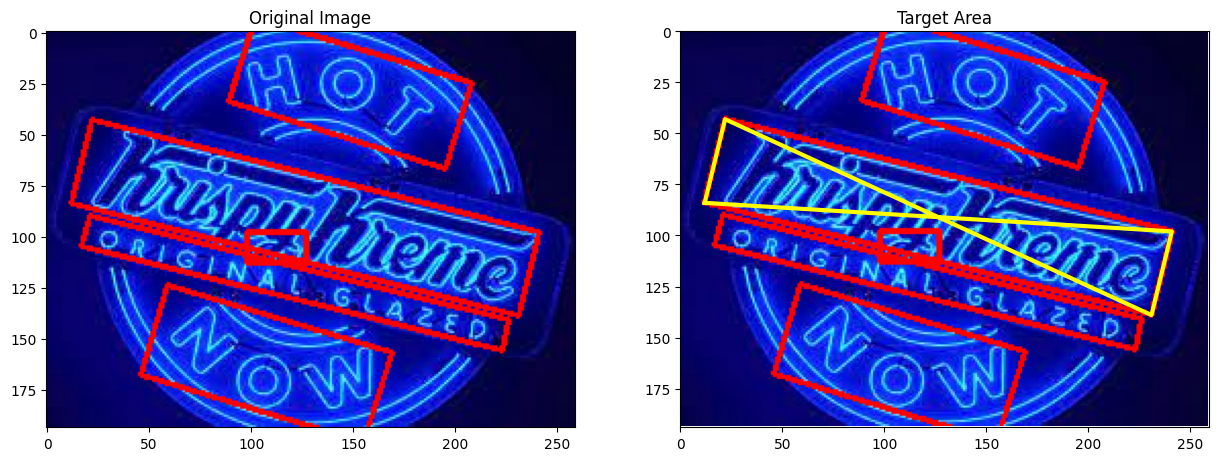

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255,   0,   0],
        [243,   0,   5],
        [122,   2,  58],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  3,   2, 106],
        [ 50,   2,  88],
        [  4,   2, 109],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [26]:
unwarp(img,angled_boxes[3],points)

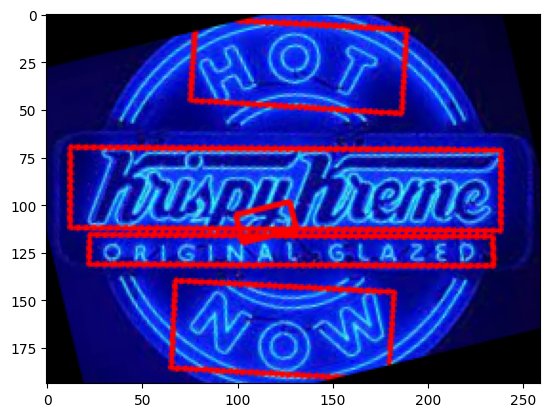

In [56]:
height, width = img.shape[:2]
center = (width // 2, height // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, 13.700000000000003, scale=1.0)
rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
plt.imshow(rotated_image)

In [53]:
import numpy as np

# Define the rectangle's corner points
rectangle_points = np.array([[12, 84], [22, 43], [241, 98], [231, 139]])

# Choose two points to calculate the slope
x1, y1 = rectangle_points[0]
x2, y2 = rectangle_points[1]

# Calculate the slope (tangent) of the rectangle's side with respect to the x-axis
slope = (y2 - y1) / (x2 - x1)

# Calculate the angle in degrees using the arctangent function
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

# Ensure the angle is positive
if angle_degrees < 0:
    angle_degrees += 180

print("Angle of the rectangle with respect to x-axis:", angle_degrees, "degrees")


Angle of the rectangle with respect to x-axis: 103.7069610040798 degrees


In [55]:
90 - 103.7

-13.700000000000003